In [4]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pylab import rcParams
from datetime import datetime
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from tslearn.clustering import TimeSeriesKMeans

rcParams['figure.figsize'] =20,10
rcParams['legend.fontsize'] = 20
font = {'family' : 'Times New Roman','weight' : "light", 'size'   : 20}
plt.rc('font', **font)

C:\Users\Philipp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [88]:
# constants  #
#------------#
HDF5_dir = "E:\\MessdatenStoeckach\\"
resampled_dir = r'E:\resampled_phasevise'
dates = os.listdir(HDF5_dir)
phases = ["1","2","3"]

In [164]:
#datelist = pd.date_range(start="2017-03-02", end="2018-02-17").strftime("%Y-%m-%d").astype(str).to_list()
datelist = pd.date_range(start="2017-03-02", end="2017-04-30").strftime("%Y-%m-%d").astype(str).to_list()

#datelist = ["2017-03-02"]

In [165]:
rmsi_all_p1 = pd.DataFrame()
shi_all_p1 = pd.DataFrame()
rmsi_all_p2 = pd.DataFrame()
shi_all_p2 = pd.DataFrame()
rmsi_all_p3 = pd.DataFrame()
shi_all_p3 = pd.DataFrame()

for date in datelist:
    rmsi_all_p1 = rmsi_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p1.p"))
    shi_all_p1 = shi_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_max_p1.p"))
    
    rmsi_all_p2 = rmsi_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p2.p"))
    shi_all_p2 = shi_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_max_p2.p"))
    
    rmsi_all_p3 = rmsi_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p3.p"))
    shi_all_p3 = shi_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_max_p3.p"))

In [92]:
#load raw rmsi data

rmsi_all_raw = pd.DataFrame()

for date in datelist:
    print(date)
    with h5py.File(HDF5_dir + date + "\\" + "phase_1" + "_" + date + ".h5", 'r') as f:
        ts = pd.to_datetime(f["tenperiodtable"]["timestamp"], unit="s").tz_localize("UTC").tz_convert("Europe/Berlin")
        rmsidf = pd.DataFrame(f["tenperiodtable"]["rms_i"], ts)
        rmsidf.index = ts
        rmsi_all_raw = rmsi_all_raw.append(rmsidf)

2017-03-02


In [166]:
rmsi2 = rmsi_all_p1[rmsi_all_p1 < 2]

In [93]:
rmsi2 = rmsi_all_raw[rmsi_all_raw < 2]

In [167]:
rmsi2 = rmsi2.dropna()

In [95]:
def split(dfm, chunk_size):
    indices = index_marks(dfm.shape[0], chunk_size)
    return np.split(dfm, indices)


In [96]:
def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

In [218]:
chunks = split(rmsi2, 18)
del chunks[-1]
for i in range(6,18,6):
    splitted = split(rmsi2[i:], 18)
    del splitted[-1]
    chunks.extend(splitted)

In [203]:
chunks

[                                  0
 2017-03-02 19:00:00+01:00  1.877666
 2017-03-02 19:10:00+01:00  1.878603
 2017-03-02 19:20:00+01:00  1.882945
 2017-03-02 19:30:00+01:00  1.883463
 2017-03-02 19:40:00+01:00  1.880305
 2017-03-02 19:50:00+01:00  1.879010,
                                   0
 2017-03-02 20:00:00+01:00  1.870835
 2017-03-02 20:10:00+01:00  1.871134
 2017-03-02 20:20:00+01:00  1.872934
 2017-03-02 20:30:00+01:00  1.870444
 2017-03-02 20:40:00+01:00  1.872895
 2017-03-02 20:50:00+01:00  1.872605,
                                   0
 2017-03-02 21:00:00+01:00  1.870836
 2017-03-02 21:10:00+01:00  1.871134
 2017-03-02 21:20:00+01:00  1.868721
 2017-03-02 21:30:00+01:00  1.868362
 2017-03-02 21:40:00+01:00  1.869279
 2017-03-02 21:50:00+01:00  1.870215,
                                   0
 2017-03-02 22:00:00+01:00  1.864864
 2017-03-02 22:10:00+01:00  1.857625
 2017-03-02 22:20:00+01:00  1.857984
 2017-03-02 22:30:00+01:00  1.857729
 2017-03-02 22:40:00+01:00  1.86157

In [219]:
chunkarray = np.dstack(chunks)

In [220]:
chunkarray = np.rollaxis(chunkarray,-1)

In [221]:
chunkarray.shape

(1216, 18, 1)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1216 out of 1216 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.6s finished


7.321 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    1.0s finished


5.797 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.646 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.633 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.615 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.612 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.609 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.608 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.607 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.606 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.605 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.605 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.5s finished


5.605 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1216 out of 1216 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


9.078 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


6.041 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.922 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.851 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.822 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.809 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.799 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.791 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.782 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.777 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.755 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.742 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.694 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.671 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.643 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.632 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.628 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.627 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.626 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.625 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.622 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.618 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.614 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.609 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.578 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.568 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.566 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.565 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.563 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.563 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.562 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.4s finished


5.561 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.528 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.516 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.508 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.503 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.486 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.484 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.477 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.474 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.472 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.472 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


5.472 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3648 out of 3648 | elapsed:    0.3s finished


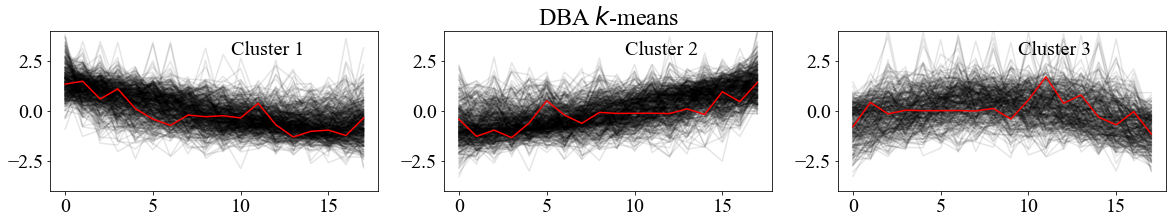

In [225]:
chunkarray = TimeSeriesScalerMeanVariance().fit_transform(chunkarray)

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=100,
                          random_state=0)
y_pred = dba_km.fit_predict(chunkarray)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in chunkarray[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")


KernelKMeans


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 739936 out of 739936 | elapsed:  3.8min finished


2415.886 --> 2412.374 --> 2409.882 --> 2408.198 --> 2407.037 --> 2406.398 --> 2405.733 --> 2405.132 --> 2404.645 --> 2404.297 --> 2403.994 --> 2403.396 --> 2403.113 --> 2402.965 --> 2402.910 --> 2402.856 --> 2402.844 --> 2402.842 --> 2402.842 --> 


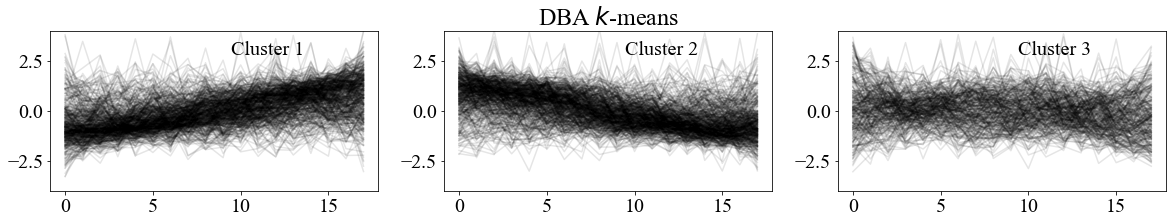

In [224]:
from tslearn.clustering import KernelKMeans

chunkarray = TimeSeriesScalerMeanVariance().fit_transform(chunkarray)

# DBA-k-means
print("KernelKMeans")
dba_km = KernelKMeans(n_clusters=3, kernel="gak", verbose=True)
y_pred = dba_km.fit_predict(chunkarray)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in chunkarray[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    #plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Kernel $k$-means")